## Unsupervised Capstone Project

### Ten articles with 10 different authors have been selected for this project. The articles are obtained from free Gutenberg Project and they are all Christmas-related.

In [1]:
import timeit
start=timeit.default_timer()

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import spacy
nlp = spacy.load('en')
from spacy.lang.en.stop_words import STOP_WORDS

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

## Load files

In [6]:
filename=['brady.txt','butler.txt','cutting.txt','dawson.txt','dyke.txt',
          'hughes.txt','mitchell.txt','richmond.txt','rinehart.txt','stretton.txt']
#filename=['brady.txt','butler.txt']

In [7]:
def load_text(filename):
    file=open(filename,'r')
    text=file.read()
    file.close
    return text

In [8]:
def clean_text(text):
    text=text.lower()
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ""
    for char in text:
       if char not in punctuations:
           no_punct = no_punct + char
    
    no_punct=no_punct.replace("ï»¿"," ")
    no_punct=no_punct.replace("\n"," ")
    
    return no_punct

In [9]:
def sep_text(text):
    text=text.split()
    
    k=60 # Number of sentences
    size=int(len(text)/k)
    para=[None]*k
    j=0
    
    for i in range(0,k):
        para[i]=text[j:j+size]
        para[i]=' '.join(para[i])
        j=j+size
    
    return para

## K-Means Clustering

In [10]:
n_max=600

In [11]:
#vectorizer = TfidfVectorizer(stop_words='english',max_features=n_max)

In [12]:
vectorizer=CountVectorizer(stop_words="english", 
                           analyzer='word', 
                           ngram_range=(1, 4), 
                           max_df=1.0, 
                           min_df=1, 
                           max_features=n_max)

In [13]:
df = pd.DataFrame()
for i in range(len(filename)):
    text=load_text(filename[i])
    text=clean_text(text)
    text=sep_text(text)
    
    X = vectorizer.fit_transform(text)
    X_np=X.todense()
    X_df=pd.DataFrame(X_np)
    
    #author=filename[i].replace('.txt','')
    #X_df['author']=author   
    X_df['author']=i
    
    df=df.append(X_df)

In [14]:
df.shape

(600, 601)

In [15]:
x=df.drop(['author'],axis=1)
y=df['author']

In [16]:
x_half1, x_half2, y_half1, y_half2 = train_test_split(x, 
                                                      y,
                                                      test_size=0.5,
                                                      random_state=0)

In [17]:
x1, x2, y1, y2 = train_test_split(x_half1, 
                                  y_half1,
                                  test_size=0.5,
                                  random_state=0)

In [18]:
x3, x4, y3, y4 = train_test_split(x_half2, 
                                  y_half2,
                                  test_size=0.5,
                                  random_state=0)

In [19]:
km = KMeans(n_clusters=10, init='k-means++', n_init=3, max_iter=100)

## Clustering Consistency

## Plot the clusters

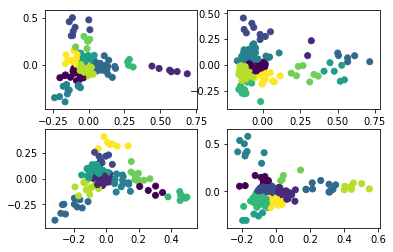

In [20]:
f,axarr=plt.subplots(2,2)
for x,i,j in [[x1,0,0],[x2,0,1],[x3,1,0],[x4,1,1]]:
    x_norm=normalize(x)
    x_pca=PCA(2).fit_transform(x_norm)
    y_pred=km.fit_predict(x_pca)
    axarr[i,j].scatter(x_pca[:,0],x_pca[:,1],c=y_pred)  

## Adjusted Rand Index

In [21]:
for x,y in [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]:
    x_norm=normalize(x)
    y_pred=km.fit_predict(x_norm)
    score=metrics.adjusted_rand_score(y, y_pred)
    print(score)

0.28724706502036385
0.3241181122083774
0.2567768447618607
0.17209161802768938


## Silhouette Coefficient

In [22]:
for x in [x1, x2, x3, x4]:
    x_norm=normalize(x)
    model = km.fit(x_norm)
    labels = model.labels_
    print(metrics.silhouette_score(x_norm, labels, metric='euclidean'))

0.014828252823456024
0.020987006649773977
0.011867157498652553
0.010986888744564672


## Clustering Accuracy

## Confusion Matrix

In [23]:
x_norm=normalize(x)
y_pred=km.fit_predict(x_norm)
print(pd.crosstab(y,y_pred))

col_0   0  1  2  3  4  5  6   7  8   9
author                                
0       2  0  8  0  1  0  1   0  1   1
1       0  0  1  7  1  0  0   0  0   0
2       0  0  1  3  0  1  0   0  7   2
3       0  1  5  0  1  0  2   1  0   1
4       0  2  3  2  0  2  3   1  2   0
5       0  1  2  1  5  0  2   1  1  10
6       2  2  2  1  2  0  1   0  3   0
7       0  0  0  0  1  9  5   1  0   2
8       0  1  0  4  4  2  1   1  2   1
9       0  4  0  0  0  0  1  11  1   0


## Accuracy Score

In [24]:
accuracy_score(y,y_pred)

0.04666666666666667

## Supervised Learning Classification

In [25]:
text_list=[]
for i in range(len(filename)):
    text=load_text(filename[i])
    text=clean_text(text)
    text=sep_text(text)
    text_list=text_list+text

text_list=[]
len_list=[None]*(len(filename)+1)
len_list[0]=0
for i in range(0,len(filename)):
    text=load_text(filename[i])
    text=clean_text(text)
    temp_list=text.split(".")
    len_list[i+1]=len_list[i]+len(temp_list)
    text_list=text_list+temp_list

In [26]:
len(text_list)

600

In [27]:
df.shape

(600, 601)

## Bag of Words

In [28]:
vectorizer=CountVectorizer(stop_words="english", 
                           analyzer='word', 
                           ngram_range=(1, 4), 
                           max_df=1.0, 
                           min_df=1, 
                           max_features=n_max)

In [29]:
x = vectorizer.fit_transform(text_list)
x = x.toarray()
x.shape

(600, 600)

In [30]:
y=df['author']

In [31]:
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                    test_size=0.25,
                                                    )

In [32]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(x_train, y_train)
print('Training set score:', rfc.score(x_train, y_train))
print('\nTest set score:', rfc.score(x_test, y_test))

Training set score: 0.9955555555555555

Test set score: 0.76


In [33]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
print('Training set score:', lr.score(x_train, y_train))
print('\nTest set score:', lr.score(x_test, y_test))

Training set score: 1.0

Test set score: 0.8933333333333333


## TFIDF

In [34]:
vectorizer = TfidfVectorizer(stop_words='english',max_features=n_max)

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )

In [35]:
x = vectorizer.fit_transform(text_list)
x = x.toarray()
x.shape

(600, 600)

In [36]:
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y,
                                                    test_size=0.25,
                                                    )

In [37]:
rfc = ensemble.RandomForestClassifier()
rfc.fit(x_train, y_train)
print('Training set score:', rfc.score(x_train, y_train))
print('\nTest set score:', rfc.score(x_test, y_test))

Training set score: 0.9977777777777778

Test set score: 0.7133333333333334


In [38]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
print('Training set score:', lr.score(x_train, y_train))
print('\nTest set score:', lr.score(x_test, y_test))

Training set score: 0.9977777777777778

Test set score: 0.8333333333333334
